In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-n332fx2j
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-n332fx2j
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2025-06-13 22:13:35--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg.2’

dog

In [3]:
pip install torch torchvision segment-anything shapely scikit-learn matplotlib opencv-python

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamPredictor
from sklearn.linear_model import LogisticRegression
from itertools import combinations
import random
import matplotlib.pyplot as plt

# **Exemple PIE implémentation sur 1 image**

Voici une première version du PIE, testée sur une seule image.

Actuellement, l’EAC détecte principalement les oreilles du chien ainsi qu’une partie de la gamelle, qui semblent être les concepts les plus importants. Mais, je pense que ce résultat peut être nettement amélioré. Par manque de ressources, j’ai pas pu tester autant de coalitions que dans l’article original (1 000 contre 50 000), ce qui limite la qualité des explications générées.

Pour reproduire la suite du papier, il faut retrouver les résultats de faithfulness, understability et ablation study.
Pour ceci, il faudrait :
- Obtenir de meilleurs résultats explicatifs sur une image individuelle.

- Implémenter un code d’évaluation de l’AUC via les méthodes d’insertion et de suppression (insertion/deletion scheme).

- Évaluer le modèle sur un ensemble plus large d’images provenant d’ImageNet et COCO.

- Mesurer la compréhensibilité des masques générés auprès de 6 annotateurs humains.

- Noter et analyser le temps de traitement pour chaque étape.

**Phase 1 : Concept Discovery**

Etape 1-2 : Charger l'image et la segmenter avec SAM

In [5]:
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

mkdir: cannot create directory ‘images’: File exists
--2025-06-13 22:13:49--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg.3’

dog.jpg.3           100%[===================>]  97.51K  --.-KB/s    in 0.003s  

2025-06-13 22:13:49 (29.3 MB/s) - ‘images/dog.jpg.3’ saved [99846/99846]

--2025-06-13 22:13:49--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.84, 13.35.37.111, 13.35.37.90, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.84|:443... connected.
HTTP request sent, awaiting response... 2

array([[[ 73,  51,  30],
        [ 73,  51,  30],
        [ 73,  51,  30],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       [[ 73,  51,  30],
        [ 73,  51,  30],
        [ 73,  51,  28],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       [[ 73,  51,  30],
        [ 73,  51,  28],
        [ 73,  51,  28],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       ...,

       [[140, 142, 154],
        [134, 133, 147],
        [134, 133, 149],
        ...,
        [139, 142, 151],
        [141, 144, 153],
        [140, 143, 152]],

       [[135, 135, 147],
        [132, 131, 145],
        [137, 139, 154],
        ...,
        [139, 142, 151],
        [140, 143, 152],
        [139, 142, 151]],

       [[130, 132, 144],
        [131, 133, 145],
        [142, 144, 157],
        ...,
        [139, 142, 151],
        [140, 143, 152],
        [140, 143, 152]]], dtype=uint8)
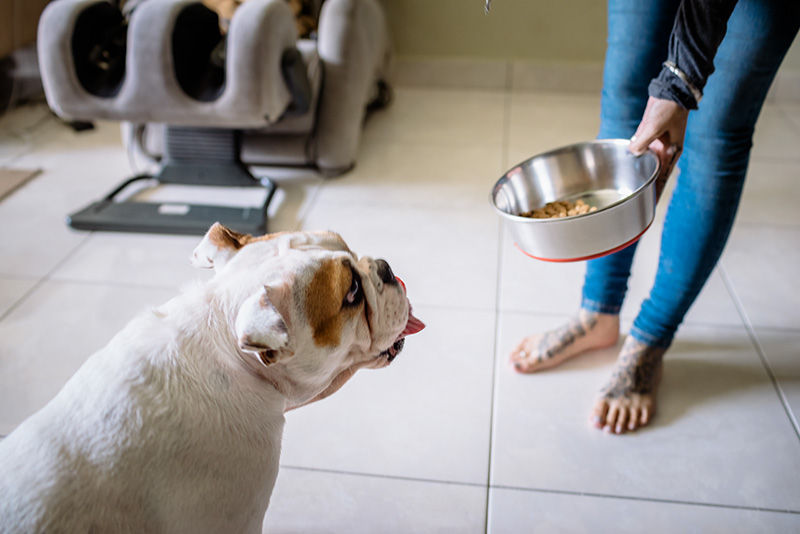

In [6]:
# eac_test_single.py
import torch
import torchvision.transforms as T
import torchvision.models as models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from tqdm import tqdm
import os
import cv2


# === Charger image de test ===
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image

In [7]:
# === Segmenter avec SAM ===
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
masks = mask_generator.generate(image)

Vérifier la segmentation de SAM

In [9]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [10]:
masks[1]['area']

186554

In [11]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

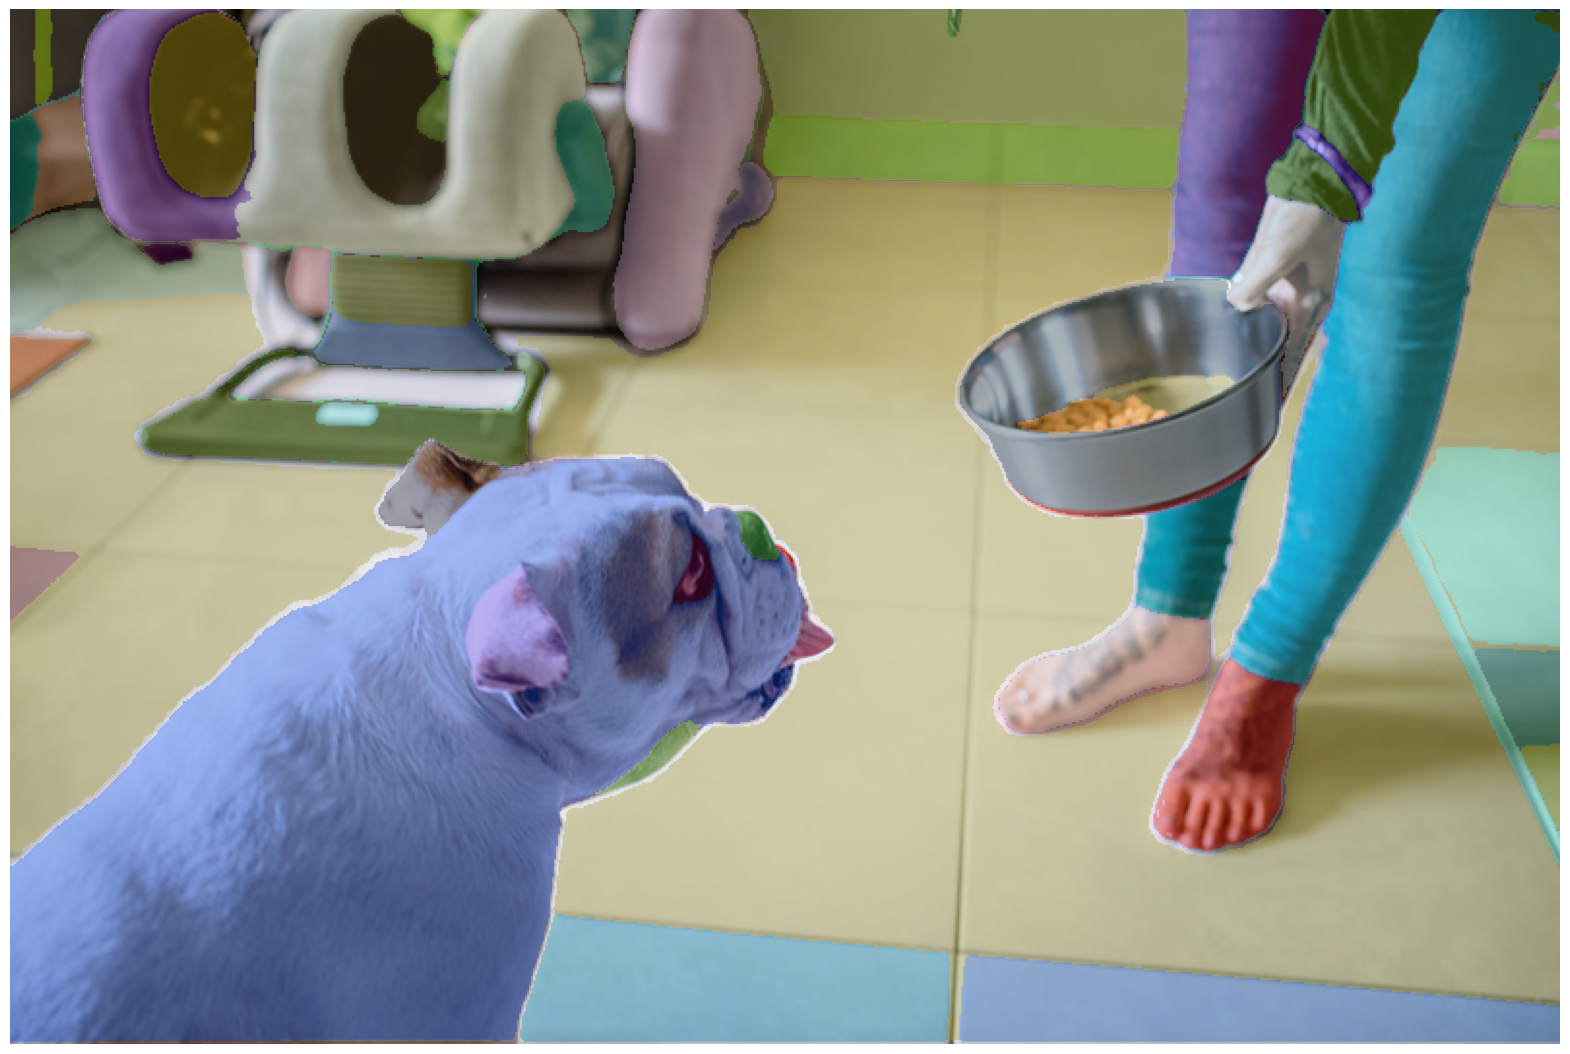

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

**Phase 2 : PIE**

Etape 3 : Charger modèle target Resnet-50

In [13]:
model = models.resnet50(pretrained=True)
model.eval()
model = model.to("cuda")
fc_layer = model.fc
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # sans FC

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]


Etape 3 : Mettre en place le Surrogate modèle

In [14]:
import torch.optim as optim

class SurrogateModel(torch.nn.Module):
    def __init__(self, fc_layer, num_concepts, feature_dim=2048, lr=0.008):
        super().__init__()
        self.h = torch.nn.Sequential(
            torch.nn.Linear(num_concepts, feature_dim),
            torch.nn.ReLU()
        )
        self.fc = fc_layer  # partagé avec ResNet

        # Freeze les paramètres
        for param in self.fc.parameters():
          param.requires_grad = False

        self.optimizer = optim.SGD(self.h.parameters(), lr=lr, momentum=0.9)

    def forward(self, b_onehot):
        features = self.h(b_onehot)
        return self.fc(features)

num_concepts = len(masks)
surrogate = SurrogateModel(fc_layer, num_concepts).to("cuda")
optimizer = torch.optim.Adam(surrogate.h.parameters(), lr=0.008)
loss_fn = torch.nn.CrossEntropyLoss()

Etape 5 : Créer le dataset d'entrainement du surrogate model = (image dont  certains concepts masqués, prédiction label du target model avec cette image masquée)

a CHANGER LE NOMBRE DE SAMPLE PAR 50 000 - Finalement, non (je crois pas précisé dans le papier)

In [15]:
import torchvision.transforms as transforms

# === créer les coalitions d’entraînement ===
def mask_image_from_concepts(concepts, concept_mask, image):
    """Masque tous les concepts sauf ceux activés dans concept_mask"""
    masked_img = image.copy()  # copie de l'image originale

    for i, mask in enumerate(concepts):
        if not concept_mask[i]:  # si le concept i doit être masqué
            masked_img[mask.astype(bool)] = 0

    masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1).float() / 255.

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    masked_img_tensor = normalize(masked_img_tensor)
    masked_img_tensor = masked_img_tensor.unsqueeze(0)

    return masked_img_tensor

samples = []
labels = []
concepts = [mask["segmentation"] for mask in masks]
for _ in range(100):
    mask_bin = np.random.randint(0, 2, size=(num_concepts,)) # c est un vecteur binaire [0 1 0 1 0 ...] : maskbin[5] = 0 = masque le cinquième concept
    x_masked = mask_image_from_concepts(concepts, mask_bin, image) # image originale masquée

    # get predictions of the target model
    with torch.no_grad():
        out = model(x_masked.to("cuda"))
        target = torch.argmax(out, dim=1).item()
    samples.append(torch.FloatTensor(mask_bin))
    labels.append(target)

samples_tensor = torch.stack(samples).to("cuda")
labels_tensor = torch.LongTensor(labels).to("cuda")

Etape 6 : Train surrogate model with the dataset

In [16]:
# === Entraîner surrogate ===
for epoch in range(200):
    surrogate.train()
    out = surrogate(samples_tensor)
    loss = loss_fn(out, labels_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("--Epoch :", epoch, "--")
    print("Loss :", loss)

--Epoch : 0 --
Loss : tensor(6.5064, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 1 --
Loss : tensor(3.1200, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 2 --
Loss : tensor(2.3419, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 3 --
Loss : tensor(2.0598, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 4 --
Loss : tensor(1.4354, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 5 --
Loss : tensor(1.4055, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 6 --
Loss : tensor(1.2681, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 7 --
Loss : tensor(1.0161, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 8 --
Loss : tensor(0.8127, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 9 --
Loss : tensor(0.8117, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 10 --
Loss : tensor(0.7647, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 11 --
Loss : tensor(0.5831, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 12 -

**Phase 3 : Concept based Explanation**

On utilise le PIE à la place du target modèl pour estimer les shapley values

Pour chaque concept calcule sa contribution : Monte Carlo sampling de coalitions

DANS PAPIER K = 50 000. Consomme trop de ressources, j'arrive pas à faire tourner sur GPU.

In [17]:
# === Approximation Shapley (MC sampling) ===
K = 1000
shapley_values = torch.zeros(num_concepts).to("cuda")

for i in range(num_concepts):
    for _ in range(K):
        if K % 100:
          print("Coalition ", K)
        S = torch.randint(0, 2, (num_concepts,), dtype=torch.float32).to("cuda")
        S[i] = 0
        S_with_ci = S.clone()
        S_with_ci[i] = 1

        pred_with_ci = surrogate(S_with_ci.unsqueeze(0)) # u(S) dans papier
        pred_without_ci = surrogate(S.unsqueeze(0)) # u(S without ci) dans le papier

        diff = pred_with_ci[0].max() - pred_without_ci[0].max()
        shapley_values[i] += diff

        del S_with_ci
        del S

shapley_values /= K

In [18]:
shapley_values

tensor([ 0.1964, -1.2648, -0.0526,  0.5303,  0.5902,  0.4378,  0.7307,  0.9141,
         0.3375,  0.3932, -0.0158,  0.5070,  0.6470,  0.6904,  0.1389,  1.1591,
         0.5433,  1.0351,  0.4622,  0.6804,  0.3452,  0.5012,  0.4600,  0.6194,
         0.2063,  0.1781,  0.2100,  0.4240,  0.1710,  0.2917,  0.5222,  0.2370,
         0.8035,  0.6689,  0.8106,  0.6534,  0.5662,  0.5795,  0.4288,  0.4784,
         0.4087,  0.7158,  0.4215,  0.7101,  0.7217,  0.3285,  0.3615,  0.7310,
         0.6024,  0.1634,  0.4939,  0.4088,  0.4870,  0.9776,  0.5372,  0.3199,
         0.4419,  0.7444, -0.1534,  0.3096,  0.6682,  0.5923,  0.5767,  0.1767,
         0.7695,  0.1573], device='cuda:0', grad_fn=<DivBackward0>)

J'ai choisi ensuite les 5 concepts avec la pls grandes valeurs de shapley (5 c'est arbitraire)

In [19]:
k = 5
_, topk_indices = torch.topk(shapley_values, k)
E = topk_indices
print("Top-k concepts contributing the most:", E.tolist())

Top-k concepts contributing the most: [15, 17, 53, 7, 34]


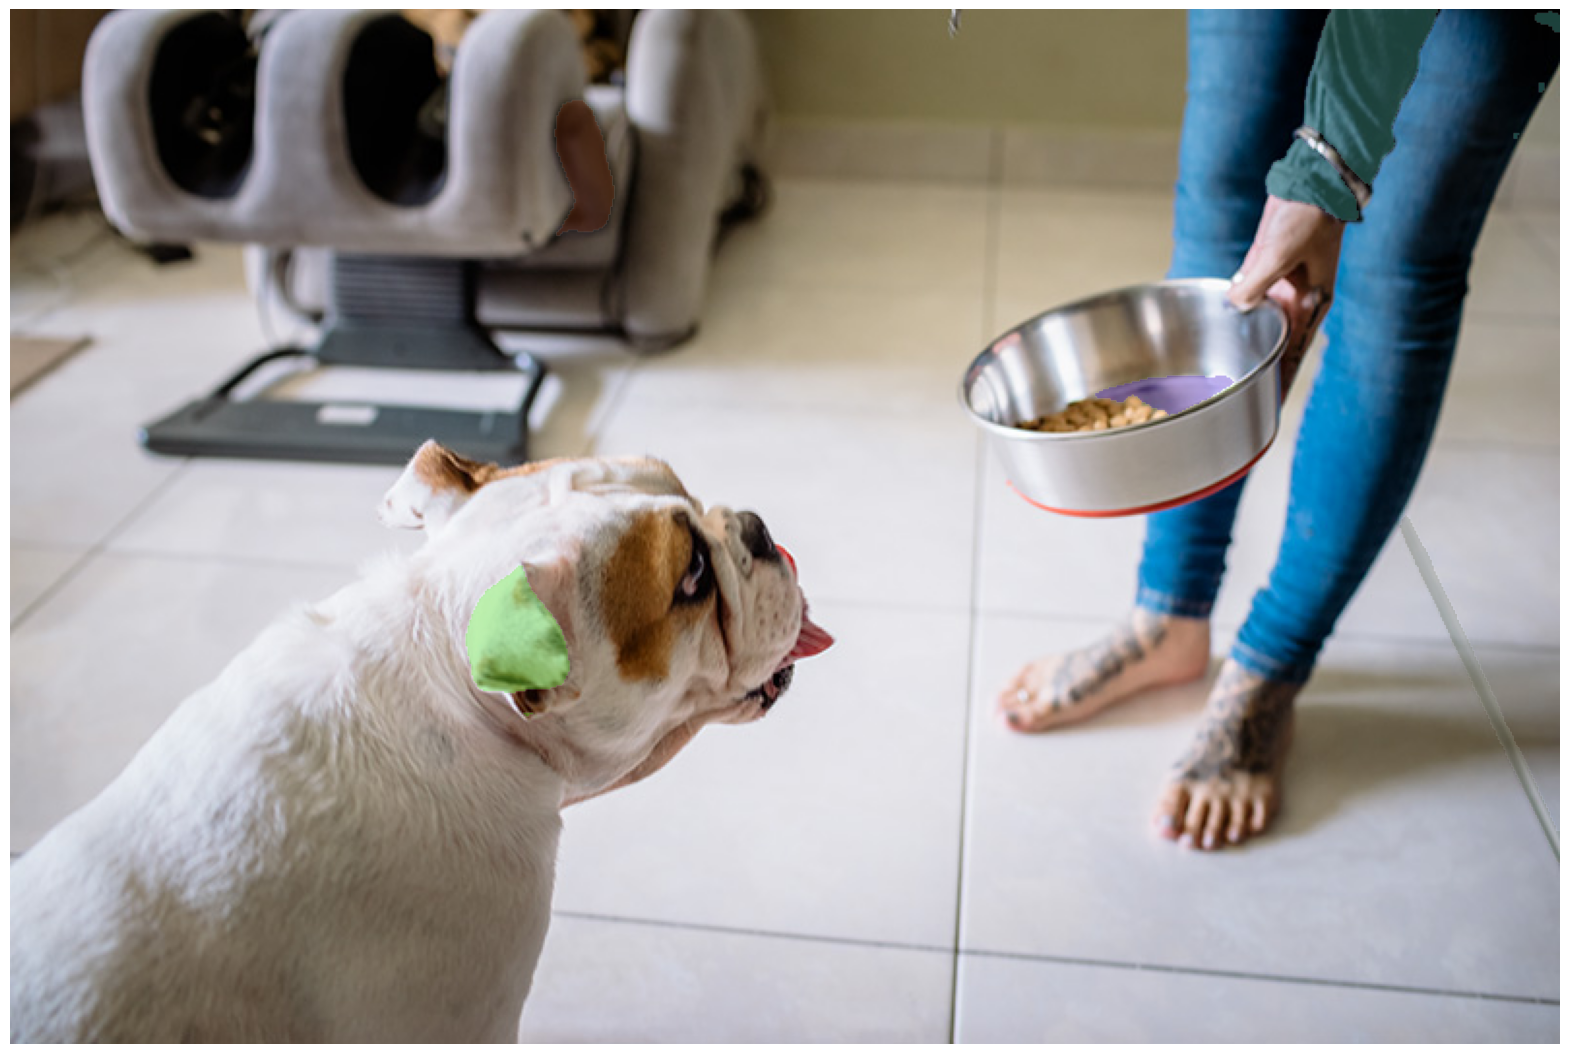

In [20]:
masks_shapley = [mask for i, mask in enumerate(masks) if i in E]
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks_shapley)
plt.axis('off')
plt.show()

Evaluation metric

Insertion scheme

Deletion scheme